# Supplemental Exercise: 
# Constructing a SigPy App

This code is directly modeled off of Frank Ong's demonstration of SigPy at ISMRM 2019. The repository for those demos can be found [here](https://github.com/mikgroup/sigpy-mri-tutorial). Here, we create an App not for reconstruction, but for pulse design.


As a supplement to the provided exercises, let's explore some of SigPy's available abstractions. We'll look at making a very simple version of the small-tip spatial-domain pTx pulse designer in the highest level of SigPy abstraction: [the App](https://sigpy.readthedocs.io/en/latest/core_app.html). We'll do this without any of the fancy constrained optimization, off-resonance correction, regularization, or other features that are included in the stspa() small-tip designer used in Exercise 4; just the bare bones of an unconstrained pTx designer to illustrate the App building process (and how so many of our pulse design functions can take advantage of existing recon code!).

This code demonstrates many of the key SigPy abstractions firsthand:

* [the Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop)
* [the Alg](https://sigpy.readthedocs.io/en/latest/core_alg.html)
* [the App](https://sigpy.readthedocs.io/en/latest/core_app.html)

We start, as always, with the appropriate import statements:

In [18]:
import sigpy as sp
import sigpy.mri as mr
import sigpy.mri.rf as rf
import sigpy.plot as pl
import numpy as np

# to assist with importing data, we will also import scipy
import scipy.io as sio

And we will re-create the inputs that we were using for the spatial domain pTx design in exercise 4:

In [72]:
dim = 32
Nc = 8
sens_shape = [Nc, dim, dim]
img_shape = [dim, dim]

# target magnetization
mat_struct = sio.loadmat('data/smallv.mat')
d = mat_struct['d']

# simulated sensitivities
sens = mr.birdcage_maps(sens_shape)

# spiral trajectory
fov = 0.55
gts = 6.4e-6
gslew = 150
gamp = 30
R = 1/2
dx = 0.025
g, k, t, s = rf.spiral_arch(fov/R,dx,gts,gslew,gamp)
k = k[::-1]
g = g[::-1]

Nt = k.shape[0]

## Linop
Linear operators are abstracted in the class [Linop](https://sigpy.readthedocs.io/en/latest/generated/sigpy.linop.Linop.html#sigpy.linop.Linop). Given a Linop A, and an appropriately shaped input x, we can compute x -> A(x) by:

```y = A(x)```

Its adjoint linear operator can be obtained using the .H attribute. Linops can be scaled, added, subtracted, stacked and composed.

The only linop necessary for a bare-bones small-tip spatial-domain designer is the adjoint of the SENSE linear operator.

### S Linop

To start, we will create a sensitivities Linop. Given some sensitivity maps, the S operator will multiply the input by the maps. We will use the Multiply Linop, which takes the input array shape and the array to be multiplied with as arguments.


In [73]:
S = sp.linop.Multiply(d.shape, sens)

### F Linop

Next, we will create a NUFFT linop. It will take the input array shape and application axes as arguments.

In [74]:
F = sp.linop.NUFFT(S.oshape, k)


### A Linop
We will chain the Linops together and form an overall A Linop for convenience. This can be done by multiplying the Linops together, then taking the adjoint of the overall linop (since we are performing a pulse design, not a SENSE reconstruction).

In [75]:
A = (F * S).H


## Alg
Alg abstracts iterative algorithms. The standard way of using an Alg, say alg, is as follows:

```while not alg.done():
    alg.update()``` 

The user is free to run other things in the while loop.

For this tutorial, we will use the Conjugate Gradient Alg.

In [77]:
max_iter = 30
alpha = 1
tol = 1e-6
pulses = np.zeros((Nc, Nt), np.complex)
alg = sp.alg.ConjugateGradient(A.H*A, A.H*d, pulses,
                                                max_iter=max_iter, tol=tol)
while not alg.done():
    alg.update()
    print('\rConjugateGradient, Iteration={}'.format(alg.iter), end='')


ConjugateGradient, Iteration=30

<Figure size 640x480 with 1 Axes>

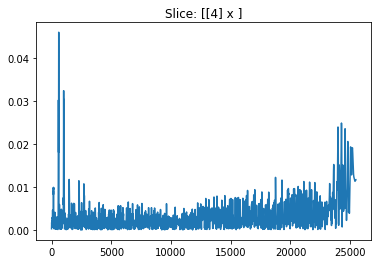

In [78]:
pl.LinePlot(pulses)


## App
Now that we know how to define the right Linop, Prox, and Alg, we can wrap all of them into an App.

An App provides a simple interface to use applications. The standard way to run an App, say app, is as follows:

```app.run()```

Each App must have a core Alg object. The run() function runs the Alg, with additional convenient features, such as a progress bar, which can be toggled with the show_pbar option.

We will copy the construction codes from above and form a SpatialPtxPulses App.



In [82]:
class SpatialPtxPulses(sp.app.App):
    def __init__(self, target, sens, coord, pulse_in,
                 max_iter=300, tol=1E-6, show_pbar=True):
                
        self.target = target
        self.sens = sens
        self.coord = coord
        self.pulses = pulse_in
        self.max_iter = max_iter
        self.tol = tol
        self.show_pbar = show_pbar
        
        device = sp.get_device(target)
        self.device = sp.Device(device)
                
        # Our system matrix for this problem is SENSE's A.H.
        # Sigpy provides this matrix as a Linop already:
        A = mr.linop.Sense(self.sens, self.coord, ishape=self.target.shape).H
        
        # solving A.H * A * pulses = A.H * m
        with self.device:
            self.alg = sp.alg.ConjugateGradient(A.H*A, A.H*self.target, self.pulses,
                                                max_iter=max_iter, tol=tol)

        super().__init__(self.alg, show_pbar=show_pbar)

    def _summarize(self):
        if self.show_pbar:
            self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.resid))

    def _output(self):
        return self.pulses

In [88]:
pulses = np.zeros((Nc, Nt), dtype=np.complex)
pulses = SpatialPtxPulses(d, sens, k, pulses, max_iter=30, tol=1e-6).run()

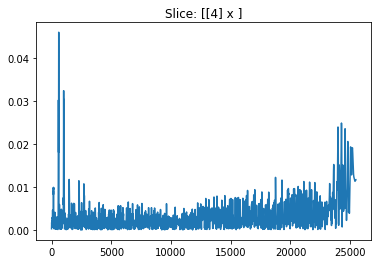

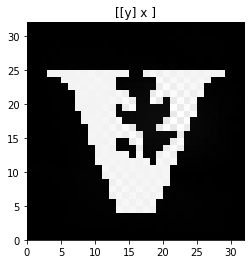

In [89]:
pl.LinePlot(pulses)
pl.ImagePlot(A * pulses)